 # <center>Transporte de Autos</center>
 
 $$\large min \sum_{ij} \pi_{ij}C_{ij} + \sum_{j} \phi(s_j)$$
 
 ### <center>Sujeto a:</center>
 
 $$\large \pi \geq 0, \sum_j \pi_{ij} = p_i$$
 
 $$\large \sum_i \pi_{ij} = s_j \quad (\mu_j)$$
  
 ## <center>Dual</center>
  
  
 $$\large L(\pi,s,\mu) = \sum_{ij} \pi_{ij}C_{ij} +  \sum_{j} \phi(s_j) - \mu_j s_j$$
 
  ## <center>Dual Primal</center>
 
 
 $$\large \bar{L}(s,\mu) = min \; L(\pi, s, \mu) = \sum_{i} p_i \: min_j \; (c_{ij} + \mu_j) + \sum_{j} \phi(s_j) - \mu_j s_j$$

## <center> Dinamica </center>

$$\large \dot{s_j} = \mu_j - \phi'(s_j)$$

$$\large \dot{\mu_j} = \sum_{i}p_i  \mathbb{1}  \{ j = argmin(c_{ij} + \mu_{j})\} - s_j$$



In [1]:
function SumarVectorColumnaAMatriz(matriz, vector)
   
    matriz_retorno = copy(matriz);
    
    cantidad_columnas = size(matriz)[2];
    
    for i in 1:cantidad_columnas
       matriz_retorno[:, i] .+= vector[i];
    end
    
    return matriz_retorno;
    
end

SumarVectorColumnaAMatriz (generic function with 1 method)

In [2]:
function ObtenerMinimoIndicePorFila(matriz)
    
    cantidad_filas = size(matriz)[1];
    
    minimos_indices = [findmin(matriz[i,:])[2] for i in 1:cantidad_filas];
    
    return minimos_indices;
    
end

ObtenerMinimoIndicePorFila (generic function with 1 method)

In [3]:
function CrearMatrizRuteoDesdeIndices(indices, dimension)
    
    A = zeros(dimension)
    
    for i in 1:dimension[1]
        A[i, indices[i]] = 1.0
    end
    
    return A;
    
end

CrearMatrizRuteoDesdeIndices (generic function with 1 method)

In [4]:
#Funcion para la matriz de ruteo A
function ObtenerMatrizRuteo(mu, C) 
    
    Aux = SumarVectorColumnaAMatriz(C, mu);
    
    indices = ObtenerMinimoIndicePorFila(Aux);
        
    A = CrearMatrizRuteoDesdeIndices(indices, size(Aux));
    
    return A;
end

ObtenerMatrizRuteo (generic function with 1 method)

In [160]:
#Función de barrera (phi'(s))
function dphi(s)
    return 1 ./ ((2.5 .-s).^2)
    #return s
end

dphi (generic function with 1 method)

In [69]:
#Función para obtener el vector de cargas a todos los j (cargadores)
function cargas(mu,C,p)
    A = ObtenerMatrizRuteo(mu, C) 
    push!(v_A, A);
    return A'*p
end

cargas (generic function with 1 method)

In [188]:
#Función para armar el sistema de ecuaciones diferenciales
function dinamica!(du,u,j,t) #Cambiar nombre
    #setup de la funcion
    
    s = u[1:cantidad_cargadores]
    mu = u[cantidad_cargadores + 1:end]
    
    ds = du[1:cantidad_cargadores]
    dmu = du[cantidad_cargadores + 1:end]
    
    v_cargas = cargas(mu,C,p)
  
    ds = 50 * (mu .- dphi(s))

    dmu = 1*(v_cargas .- s)
    
    du[1:cantidad_cargadores] = ds
    du[cantidad_cargadores + 1:end] = dmu


end

dinamica! (generic function with 1 method)

In [189]:
#using Pkg;Pkg.resolve()
using DifferentialEquations

p = ones(4);

cantidad_autos = 4;
cantidad_cargadores = 2;

p = ones(cantidad_autos);

C = 5 * rand(cantidad_autos,cantidad_cargadores)

# C = [1.0 30.0; 1.0 27.0; 1.0 24.0; 30.0 1];

# cantidad_autos = size(C)[1]
# cantidad_cargadores = size(C)[2]

v_A = [];

u0 = zeros(cantidad_cargadores * 2)
tspan = (0.0,150.0)
prob = ODEProblem(dinamica!,u0,tspan)
sol = solve(prob, saveat = 0.1);

sol_final = sol.u[end];


In [190]:
C

4×2 Matrix{Float64}:
 2.98288  1.58886
 4.17729  4.88832
 0.72997  1.52244
 1.45964  4.2972

In [10]:
function CreateHeaderString(columnas)

    header_string = String[]

    for i in 1:2*columnas

        if i <= cantidad_cargadores
            push!(header_string, string("s",i))
        else
            push!(header_string, string("mu",i - cantidad_cargadores))
        end
    end
    
    return header_string;
    
end

CreateHeaderString (generic function with 1 method)

In [191]:
# using Pkg;Pkg.add("PrettyTables")
using PrettyTables

header_string = CreateHeaderString(cantidad_cargadores);

pretty_table(sol_final'; header = header_string)


┌─────────┬─────────┬─────────┬─────────┐
│      s1 │      s2 │     mu1 │     mu2 │
├─────────┼─────────┼─────────┼─────────┤
│ 2.02224 │ 1.97772 │ 4.38098 │ 3.66609 │
└─────────┴─────────┴─────────┴─────────┘


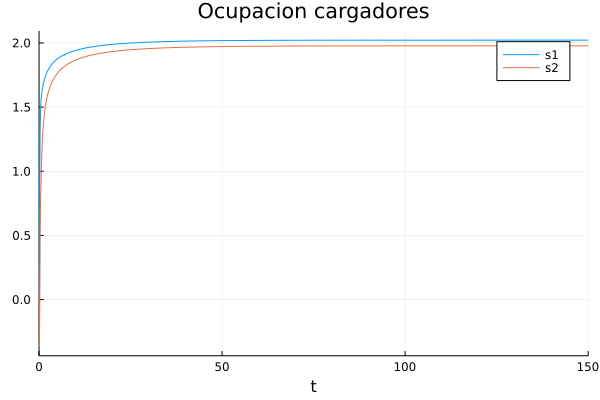

In [192]:
using Plots 
plot(sol, label = ["s1" "s2"], title = "Ocupacion cargadores", vars = [1,2])

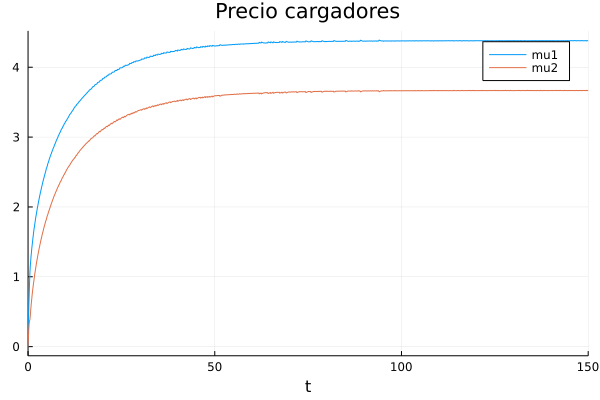

In [193]:
using Plots 
plot(sol, label = ["mu1" "mu2"], title = "Precio cargadores", vars = [3,4])

In [87]:
function GetMatrixRowInVector(matrix,row)

    return getindex.(matrix, row,:);
    
end

GetMatrixRowInVector (generic function with 1 method)

In [65]:
function CrearVectorCargadores(cantidad_cargadores)
    
    s = ones(cantidad_cargadores);
    
    for i = 1:cantidad_cargadores
       s[i] = i; 
    end
    
    return s;
    
end

CrearVectorCargadores (generic function with 1 method)

In [96]:
function ObtenerHistoriaDeCargadorPorAuto(v_A, indice_auto)
    
    v_A_auto = GetMatrixRowInVector(v_A,indice_auto);

    largo_A = size(v_A_auto)[1];
    
    ruteos = copy(v_A_auto);
    
    for i = 1:largo_A
    
        ruteos[i] = v_A_auto[i] .* s;
    end
    
    v_ruteos = zeros(largo_A);
    
    for i = 1:cantidad_cargadores
        v_ruteos += getindex.(ruteos,i);
    end
        
    return v_ruteos;
    
end

ObtenerHistoriaDeCargadorPorAuto (generic function with 3 methods)

In [ ]:
function ObtenerHistoriaDeCargadores(v_A, indice_auto)
    
    largo_A = size(v_A)[1];
    
    v_ruteos = zeros(largo_A, cantidad_cargadores)
end

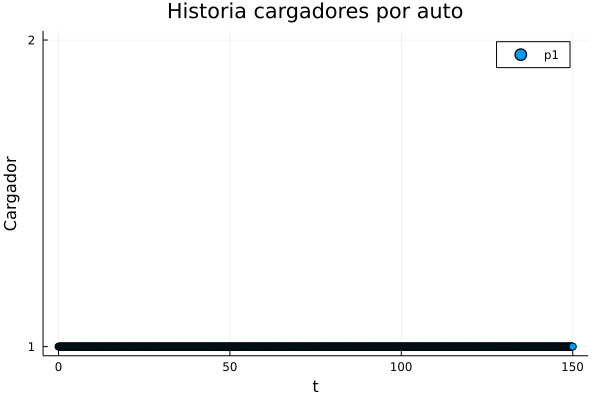

In [198]:
s = CrearVectorCargadores(cantidad_cargadores)

v_ruteos_auto1 = ObtenerHistoriaDeCargadorPorAuto(v_A, 4)

scatter(sol.t,v_ruteos_auto1, title = "Historia cargadores por auto", xlabel = "t", ylabel = "Cargador", label = "p1", yticks = s)

In [199]:
C

4×2 Matrix{Float64}:
 2.98288  1.58886
 4.17729  4.88832
 0.72997  1.52244
 1.45964  4.2972